In [1]:
from gensim.models import Word2Vec
import gensim.downloader as api
from pathlib import Path
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import numpy as np
import re
from keras.preprocessing.text import one_hot, Tokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import tensorflow
from io import StringIO
import pandas as pd
import numpy as np 
import keras
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer 
from keras.utils import pad_sequences 
from keras.models import Sequential, Model
from keras.layers import Flatten, Input, Concatenate, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, GRU, MultiHeadAttention, Add, Bidirectional,  Activation, Dropout, Dense, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import seaborn as sns
import nltk
from numpy import asarray
from numpy import zeros
from keras.layers import Conv1D
from keras.layers import LSTM
import json
from keras.optimizers import Adam
from tensorflow.keras.utils import serialize_keras_object
from tensorflow.keras import utils
from tensorflow.keras.models import clone_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
import joblib
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
lemmatizer = WordNetLemmatizer()
text_tokenizer = nltk.RegexpTokenizer(r"\w+")

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from nltk.corpus import wordnet



2023-09-24 16:41:26.273308: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 16:41:26.380339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 16:41:26.381154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 16:41:26.998626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


/tmp/ipykernel_3353/1736333401.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
[nltk_data] Downloading package stopwords to /home/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

## Load in training data

In [4]:
import os
current_dir = os.getcwd()
relative_path = 'Dataset/fin_news_optimized_6.csv'
file_path = os.path.join(current_dir, relative_path)

fin_news_1 = pd.read_csv(file_path)

<Axes: xlabel='labels', ylabel='count'>

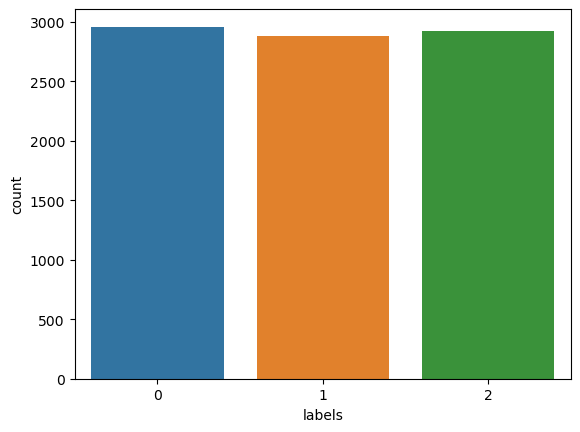

In [5]:
sns.countplot(x='labels', data=fin_news_1)

## Load text embedding

In [6]:
rel_embedding_folder_path = 'Word embedings/FinText_Word2Vec_CBOW/Word_Embedding_2000_2015'
embedding_folder_path = os.path.join(current_dir, rel_embedding_folder_path)

FinText_Word2Vec_cbow = Word2Vec.load(embedding_folder_path)

## Pre-processing data

In [7]:
def preprocess_sentence(text_):

    # Remove links, mentions     
    # reduce all text to lower case
    text_ = text_.lower()

    #Remove mentions
    text_ = re.sub('@\S+', ' ', text_)
    
    #Remove any links
    text_ = re.sub('https?:\S+|http?:\S', ' ', text_)
    
    # Remove puntuations and numbers
    text_ = re.sub('[^a-zA-Z]', ' ', text_)

    # Single character removal 
    text_ = re.sub(r"\s+[a-zA-z]\s+", ' ', text_)

    # Remove multiple spaces
    text_ = re.sub(r'\s+', ' ', text_)
    
    # Lematize
#     tokens_result = tokenizer.tokenize(tweet_)
#     pos_tuple_list = nltk.pos_tag(tokens_result)
#     POS_TRANSLATED = 
#     POS_TRANS()
#     lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens_result]

#     combined_sentence = " ".join(lemmatized_tokens)
#     pattern_ = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
#     tweet_ = pattern_.sub('', tweet_)

    return text_


def Xtrain_pre_processing(x_feature):
    feature = []
    text_ = list(x_feature)
    for txt in text_:
        sent = preprocess_sentence(txt)
#         sent = clean_text(txt)
        
#         extr_con_val = extract_concept_value_pairs(sent)
        feature.append(sent)
    return feature


In [8]:
X = Xtrain_pre_processing(fin_news_1['sentence'])
fin_news_1['labels'] = fin_news_1['labels'].astype(int)
y = fin_news_1['labels']

In [9]:
X0_train, X0_test, y0_train, y0_test =  train_test_split(X, y, test_size = 0.25, random_state = 42)

## Preparing the Embedding Layer

In [10]:
word_tokenizer = Tokenizer()

word_tokenizer.fit_on_texts(X0_train)

vocab_size = len(word_tokenizer.word_index) + 1
vocab_size

13218

In [11]:
#  This function prepares the embedding layer for our NN, it takes in the feature input and returns a tokenized array with padding 
def prep_embedding_layer(feature_, posit_of_padd_, max_padd_len):


    feature_ = word_tokenizer.texts_to_sequences(feature_)

    feature_ = pad_sequences(feature_, padding=posit_of_padd_, maxlen=max_padd_len, truncating='post')
    
    return feature_

In [12]:
max_length_ = FinText_Word2Vec_cbow.wv['word'].shape[0]

In [13]:
X0_train_emb = prep_embedding_layer(X0_train, 'post', max_length_)
X0_test_emb = prep_embedding_layer(X0_test, 'post', max_length_)

In [14]:
y0_train_OHE =  tensorflow.keras.utils.to_categorical(y0_train, num_classes=3)
y0_test_OHE =  tensorflow.keras.utils.to_categorical(y0_test, num_classes=3)

In [15]:
X0_train[0]

'ragutis which is controlled by the finnish brewery reported per cent rise in beer sales to million litres and held an per cent market share '

In [16]:
print((X0_train_emb.shape, X0_test_emb.shape ))

((6570, 300), (2191, 300))


## Loading Embeddings

In [17]:
FinText_Word2Vec_cbow.wv['hi']

array([-4.51023722e+00,  1.17607497e-01, -3.27431154e+00, -1.40505934e+00,
        3.14249486e-01, -2.11920306e-01, -1.72016072e+00,  5.37094593e-01,
       -3.95378494e+00, -6.92856669e-01,  3.50354123e+00,  1.49054599e+00,
       -5.58598340e-01,  1.12996578e+00,  6.63641632e-01, -3.05580044e+00,
        6.20447874e-01, -5.44819355e-01,  6.96304560e-01, -2.11278439e+00,
       -3.76779675e+00, -1.73961878e+00,  4.93319809e-01, -3.14829081e-01,
        6.86451256e-01,  1.52364194e+00, -2.00060591e-01,  3.86532307e-01,
       -1.53610408e-01, -1.77160883e+00,  2.80607753e-02,  1.22032082e+00,
       -4.16347146e-01, -9.62410450e-01, -2.11797404e+00,  6.27330422e-01,
       -1.75154424e+00, -8.21619749e-01, -2.29648232e+00, -8.59637201e-01,
        4.32372332e-01,  8.03456724e-01, -2.33668518e+00,  2.31352997e+00,
        1.22178578e+00,  1.64005601e+00, -9.44048524e-01, -2.46824786e-01,
        1.92423868e+00,  1.32232332e+00, -3.52571368e+00,  4.44551051e-01,
       -1.05939007e+00,  

In [18]:
len(FinText_Word2Vec_cbow.wv['amazon'])

300

Length should be == 300

In [1]:
def initialize_FinText(vocabSize, maxLength, wordInd, word_emb_model ):
    """
    Initialize an embedding matrix for financial text data.

    Args:
        vocabSize (int): The size of the vocabulary.
        maxLength (int): The maximum length of input sequences.
        wordInd (dict): A dictionary mapping words to their indices.
        word_emb_model (Word2Vec): A Word2Vec word embedding model.

    Returns:
        np.ndarray: An embedding matrix for the vocabulary.

    This function initializes an embedding matrix for financial text data using a Word2Vec word embedding model.
    It maps words in the vocabulary to their corresponding word vectors in the embedding model.
    If a word is not found in the model, its corresponding row in the matrix is filled with zeros.

    """
    matrix = np.zeros((vocabSize, maxLength))  
    for word, i in wordInd.items():
        if word in FinText_Word2Vec_cbow.wv: 
            vector_ = word_emb_model[word]
            if vector_ is not None:
                matrix[i] = vector_
            
    return matrix

In [20]:
embedding_matrix = initialize_FinText(vocab_size, max_length_, word_tokenizer.word_index, FinText_Word2Vec_cbow.wv)

In [21]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.50167179e+00,  1.21402717e+00, -4.04431677e+00, ...,
         3.54783863e-01,  1.30911125e-03,  1.70508897e+00],
       [-1.44555199e+00,  3.73404324e-01, -1.89970732e+00, ...,
         3.63037825e+00,  3.83989215e+00,  1.09370947e+00],
       ...,
       [-5.22889048e-02,  2.71966886e-02, -1.10525861e-02, ...,
        -4.06878963e-02, -5.63146826e-03,  5.72349057e-02],
       [-3.15693212e+00,  1.23764314e-01, -2.07463408e+00, ...,
        -3.86529982e-01,  2.21590805e+00, -2.57768512e+00],
       [-1.31619895e+00, -3.45596075e-01, -5.59330761e-01, ...,
         2.25437954e-01,  2.21739560e-01,  6.34576797e-01]])

In [22]:
X0_train[0]

'ragutis which is controlled by the finnish brewery reported per cent rise in beer sales to million litres and held an per cent market share '

In [23]:
X0_train_emb[0]

array([2236,   51,    9, 1647,   17,    1,   28, 2571,  237,   92,  513,
        217,    3,  885,   26,    4,   30, 2977,    5,  541,   27,   92,
        513,   44,   47,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [24]:
if embedding_matrix.shape[1] == 300:
    print('True')
    embedding_dim = embedding_matrix.shape[1]

True


In [3]:
import pickle

# file path where the tokenizer is saved to re-build the trained model
file_path = os.path.join(current_dir, 'Tokenizers/tokenizer_bi_att_1.pkl')

# Save the tokenizer to the specified file path
with open(file_path, 'wb') as tokenizer_file:
    pickle.dump(word_tokenizer, tokenizer_file)
    

## Create Model

### Define Custom Metrics

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Derive balancing weight values
Due to the datasets slight unbalanced nature, we would need to add class weights in order to eliminate bias towards the class that holds the highest volumen of data

In [27]:
type(y0_train)

pandas.core.series.Series

In [28]:
y0_train_emb = np.array(y0_train)

In [29]:
from sklearn.utils.class_weight import compute_class_weight

In [30]:
class_weights = compute_class_weight('balanced', classes=np.unique(y0_train_emb), y=y0_train_emb)
class_weight_dict = dict(enumerate(class_weights))

In [31]:
class_weight_dict

{0: 1.0027472527472527, 1: 1.0032065964269354, 2: 0.994098955969133}

### Creating the attention layer

In [7]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        Initialize the MyAttention layer.

        Args:
            units (int): The number of units for the attention mechanism.
        """
        super(MyAttention, self).__init__()
        self.units = units
        
        # Define three dense layers for weight calculations
        self.dense1 = tf.keras.layers.Dense(units)
        self.dense2 = tf.keras.layers.Dense(units)
        self.dense3 = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        """
        Perform the forward pass of the MyAttention layer.

        Args:
            features (tf.Tensor): The input features.
            hidden (tf.Tensor): The hidden state.

        Returns:
            contxt_vector (tf.Tensor): The context vector.
            att_weights (tf.Tensor): The attention weights.
        """
        # Expand the dimensions of the hidden state
        hidden_timeA = tf.expand_dims(hidden, 1)
        
        # Calculate the attention score using tanh activation
        score = tf.nn.tanh(self.dense1(features) + self.dense2(hidden_timeA))
        
        # Apply softmax to obtain attention weights
        att_weights = tf.nn.softmax(self.dense3(score), axis=1)
        
        # Calculate the context vector by element-wise multiplication
        contxt_vector = att_weights * features
        # Sum the context vector along axis 1
        contxt_vector = tf.reduce_sum(contxt_vector, axis=1)

        # Return the context vector and attention weights
        return contxt_vector, att_weights

    def get_config(self):
        config = super(MyAttention, self).get_config()
        config.update({'units': self.units})
        return config

## Build Model & Hyper Parameter Tuning Helper Fucntion

Split dataset AGAIN

In [34]:
X1_train_emb, X1_val_emb, y1_train_OHE, y1_val_OHE =  train_test_split(X0_train_emb, y0_train_OHE, test_size = 0.25, random_state = 42)

#### Save model in folder

In [37]:
lstm_nn_path = os.path.join(current_dir, 'Model/Saved_Hyp_Bi_ATT_2_model')

monitor_acc = 'val_acc'
monitor_auc = 'val_AUC'
checkpointer = ModelCheckpoint(filepath=lstm_nn_path,
                               verbose=1,
                               monitor=monitor_auc,
                               mode='max',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor=monitor_auc,
                               patience=5,
                               mode='max',
                               restore_best_weights=True)

### Begin Hyper-Param Tuning 

In [40]:
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
import numpy as np


# Define Hyperparameter Search Space
hp = kt.HyperParameters()
hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
hp.Int('lstm_units', min_value=32, max_value=256, step=32)
hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
hp.Int('num_lstm_layers', min_value=1, max_value=3, step=1)  # Number of LSTM layers
hp.Int('batch_size', min_value=32, max_value=128, step=32)  # Batch size
hp.Int('attention_units', min_value=10, max_value=50, step=10)  # Attention units

# Define Model-Building Function
def build_model(hp):
    sequence_input = Input(shape=(X0_train_emb.shape[1],), dtype="int32")
    embedded_sequences = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(sequence_input)

    # Create LSTM layers based on the hyperparameter 'num_lstm_layers'
    lstm_layers = []
    for _ in range(hp.Int('num_lstm_layers', min_value=1, max_value=3, step=1)):
        lstm = Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=256, step=32), return_sequences=True))(embedded_sequences)
        lstm_layers.append(lstm)
    
    # Concatenate LSTM layers if there are multiple
    if len(lstm_layers) > 1:
        lstm = Concatenate()(lstm_layers)
    else:
        lstm = lstm_layers[0]

    (lstm, f_hidden, f_cell, b_hidden, b_cell) = Bidirectional(LSTM(32, return_sequences=True, return_state=True), name="biDir_1")(lstm)
    
    # We concatenate the forward and backward hidden states (`f_hidden` and `b_hidden`) as well as the cell states respectively.
    # This concatenation combines information from both directions of the sequence.
    s_hidden = Concatenate()([f_hidden, b_hidden])
    s_cell = Concatenate()([f_cell, b_cell])
    # We apply an attention mechanism to the LSTM output `lstm` and the concatenated states.
    #The attention mechanism calculates a context vector and attention weights for each time step in the sequence.
    contxt_vector, att_weights = MyAttention(hp.Int('attention_units', min_value=10, max_value=50, step=10))(lstm, s_hidden)

    # Dense Layers and Model Compilation
    # We pass the contxt_vector through a dense layer with ReLU activation.
    dense1 = Dense(20, activation="relu")(contxt_vector)
    # Dropout reg applied to reduce overfitting.
    dropout = Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))(dense1)
    # Final softmax activation dense layer which generates the output probabilities.
    output = Dense(3, activation="softmax")(dropout)

    model = Model(inputs=sequence_input, outputs=output)
    
    # The model is compiled with an Adam optimizer, categorical cross-entropy loss,along with AUC, f1, precision, and recall evaluation metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['acc', keras.metrics.AUC(name='AUC'), f1_m,precision_m, recall_m]
    )
    return model

# Define a Keras Tuner Object 
tuner = kt.Hyperband(build_model,
                     objective='val_AUC',
                     max_epochs=25,
                     factor=3,
                     directory='my_dir',
                     project_name='Bi_ATT_3_Model')

# Perform Hyperparameter Search
tuner.search(x=X1_train_emb,
             y= y1_train_OHE,
             epochs=25,
             batch_size=hp.Int('batch_size', min_value=32, max_value=128, step=32),  # Batch size
             validation_data=(X1_val_emb, y1_val_OHE), 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Retrieve the Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 16m 20s]
val_AUC: 0.9477589130401611

Best val_AUC So Far: 0.9484665393829346
Total elapsed time: 02h 34m 40s


In [41]:
best_model

In [42]:
for key,value in best_hps.values.items():
    print(f"{key}: {value}")

num_lstm_layers: 3
lstm_units: 160
attention_units: 10
dropout: 0.2
learning_rate: 0.0036965286941307712
tuner/epochs: 9
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0


Optimal model parameters are defined above, we will begin training a fresh model based on these hyper parameters.

In [44]:
monitor_acc = 'val_acc'
monitor_auc = 'val_AUC'
checkpointer = ModelCheckpoint(filepath=lstm_nn_path,
                               verbose=1,
                               monitor=monitor_auc,
                               mode='max',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor=monitor_auc,
                               patience=4,
                               mode='max',
                               restore_best_weights=True)


tuned_hype_best_model = build_model(best_hps)
tuned_hype_best_model_hist = tuned_hype_best_model.fit(X0_train_emb, 
                                                       y0_train_OHE,
                                                       epochs=9,
                                                       batch_size=32,
                                                      validation_split=0.2,
                                                      callbacks=[early_stopping, checkpointer])

Epoch 1/9


165/165 [==============================] - ETA: 0s - loss: 0.6804 - acc: 0.7062 - AUC: 0.8735 - f1_m: 0.6767 - precision_m: 0.7444 - recall_m: 0.6269
Epoch 1: val_AUC improved from -inf to 0.92830, saving model to /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model
INFO:tensorflow:Assets written to: /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model/assets


INFO:tensorflow:Assets written to: /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model/assets


165/165 [==============================] - 154s 892ms/step - loss: 0.6804 - acc: 0.7062 - AUC: 0.8735 - f1_m: 0.6767 - precision_m: 0.7444 - recall_m: 0.6269 - val_loss: 0.5184 - val_acc: 0.7900 - val_AUC: 0.9283 - val_f1_m: 0.7828 - val_precision_m: 0.8287 - val_recall_m: 0.7455
Epoch 2/9
165/165 [==============================] - ETA: 0s - loss: 0.4278 - acc: 0.8385 - AUC: 0.9500 - f1_m: 0.8343 - precision_m: 0.8557 - recall_m: 0.8146
Epoch 2: val_AUC improved from 0.92830 to 0.92956, saving model to /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model
INFO:tensorflow:Assets written to: /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model/assets


INFO:tensorflow:Assets written to: /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model/assets


165/165 [==============================] - 145s 877ms/step - loss: 0.4278 - acc: 0.8385 - AUC: 0.9500 - f1_m: 0.8343 - precision_m: 0.8557 - recall_m: 0.8146 - val_loss: 0.5188 - val_acc: 0.7968 - val_AUC: 0.9296 - val_f1_m: 0.7966 - val_precision_m: 0.8121 - val_recall_m: 0.7820
Epoch 3/9
165/165 [==============================] - ETA: 0s - loss: 0.2976 - acc: 0.8853 - AUC: 0.9753 - f1_m: 0.8834 - precision_m: 0.8941 - recall_m: 0.8733
Epoch 3: val_AUC improved from 0.92956 to 0.94426, saving model to /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model
INFO:tensorflow:Assets written to: /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model/assets


INFO:tensorflow:Assets written to: /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model/assets


165/165 [==============================] - 141s 854ms/step - loss: 0.2976 - acc: 0.8853 - AUC: 0.9753 - f1_m: 0.8834 - precision_m: 0.8941 - recall_m: 0.8733 - val_loss: 0.4739 - val_acc: 0.8204 - val_AUC: 0.9443 - val_f1_m: 0.8249 - val_precision_m: 0.8348 - val_recall_m: 0.8155
Epoch 4/9
165/165 [==============================] - ETA: 0s - loss: 0.2233 - acc: 0.9153 - AUC: 0.9858 - f1_m: 0.9165 - precision_m: 0.9224 - recall_m: 0.9108
Epoch 4: val_AUC did not improve from 0.94426
165/165 [==============================] - 127s 768ms/step - loss: 0.2233 - acc: 0.9153 - AUC: 0.9858 - f1_m: 0.9165 - precision_m: 0.9224 - recall_m: 0.9108 - val_loss: 0.5527 - val_acc: 0.7983 - val_AUC: 0.9378 - val_f1_m: 0.7920 - val_precision_m: 0.7985 - val_recall_m: 0.7857
Epoch 5/9
165/165 [==============================] - ETA: 0s - loss: 0.1757 - acc: 0.9395 - AUC: 0.9906 - f1_m: 0.9382 - precision_m: 0.9414 - recall_m: 0.9352
Epoch 5: val_AUC did not improve from 0.94426
165/165 [=================

In [49]:
tuned_hype_best_model_optimized_1 = build_model(best_hps)
tuned_hype_best_model_optimized_hist_1 = tuned_hype_best_model_optimized_1.fit(X0_train_emb, 
                                                       y0_train_OHE,
                                                       epochs=4,
                                                       batch_size=32,
                                                      validation_split=0.2,
                                                      callbacks=[early_stopping, checkpointer])

Epoch 1/4
165/165 [==============================] - ETA: 0s - loss: 0.7752 - acc: 0.6433 - AUC: 0.8316 - f1_m: 0.5507 - precision_m: 0.7206 - recall_m: 0.4922
Epoch 1: val_AUC did not improve from 0.94426
165/165 [==============================] - 124s 712ms/step - loss: 0.7752 - acc: 0.6433 - AUC: 0.8316 - f1_m: 0.5507 - precision_m: 0.7206 - recall_m: 0.4922 - val_loss: 0.5439 - val_acc: 0.7740 - val_AUC: 0.9217 - val_f1_m: 0.7670 - val_precision_m: 0.7924 - val_recall_m: 0.7440
Epoch 2/4
165/165 [==============================] - ETA: 0s - loss: 0.4435 - acc: 0.8288 - AUC: 0.9466 - f1_m: 0.8247 - precision_m: 0.8459 - recall_m: 0.8051
Epoch 2: val_AUC did not improve from 0.94426
165/165 [==============================] - 116s 701ms/step - loss: 0.4435 - acc: 0.8288 - AUC: 0.9466 - f1_m: 0.8247 - precision_m: 0.8459 - recall_m: 0.8051 - val_loss: 0.4647 - val_acc: 0.8158 - val_AUC: 0.9417 - val_f1_m: 0.8040 - val_precision_m: 0.8297 - val_recall_m: 0.7805
Epoch 3/4
165/165 [=======

INFO:tensorflow:Assets written to: /home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model/assets


165/165 [==============================] - 133s 804ms/step - loss: 0.2278 - acc: 0.9148 - AUC: 0.9847 - f1_m: 0.9146 - precision_m: 0.9213 - recall_m: 0.9081 - val_loss: 0.4669 - val_acc: 0.8234 - val_AUC: 0.9464 - val_f1_m: 0.8171 - val_precision_m: 0.8351 - val_recall_m: 0.8036


In [50]:
tuned_hype_best_model_optimized_1.evaluate(X0_test_emb, y0_test_OHE)

69/69 [==============================] - 10s 152ms/step - loss: 0.4624 - acc: 0.8288 - AUC: 0.9485 - f1_m: 0.8308 - precision_m: 0.8377 - recall_m: 0.8242


[0.46237823367118835,
 0.8288452625274658,
 0.9485046863555908,
 0.8307753205299377,
 0.8377188444137573,
 0.8242149949073792]

In [8]:
tuned_hype_best_model_optimized_1.summary()

In [55]:
test = pd.DataFrame({
    'title': [""" Oil giant Shell reports highest quarterly profit since 2008 on soaring commodity prices"""],
    'article': ["""Oil giant Shell on Thursday reported its highest quarterly profit since 2008 on soaring commodity prices, fueling calls for a one-off windfall tax on oil and gas companies to help U.K. households with spiraling energy bills. Shell posted adjusted earnings of $9.1 billion for the three months through to the end of March, in line with expectations of analysts polled by Refinitiv. That compared with $3.2 billion over the same period a year earlier and $6.4 billion for the fourth quarter of 2021.

The company also announced plans to increase its dividend by around 4% to $0.25 per share for the first quarter.

Of the firm’s $8.5 billion share buyback program announced for the first half of the year, Shell said $4 billion had been completed to date. The remaining $4.5 billion share buybacks are scheduled to be completed before the announcement of second-quarter earnings.

Shares of the company rose 3% on Thursday morning.

Shell’s results echo bumper profits seen across the oil and gas industry, even as many energy majors incur costly write-downs from exiting Russia. U.K. rival BP on Tuesday announced plans to boost share buybacks after first-quarter net profit jumped to its highest level in more than a decade. France’s TotalEnergies, Norway’s Equinor and U.S. oil giants Chevron and Exxon Mobil also reported strong first-quarter profits on soaring commodity prices.

Shell confirmed it had taken $3.9 billion of post-tax charges in the first quarter as a result of its exit from Russia. The company had previously warned it could write off between $4 billion and $5 billion in the value of its assets after pulling out of the country. The firm said these charges were not expected to impact adjusted earnings.

“The war in Ukraine is first and foremost a human tragedy, but it has also caused significant disruption to global energy markets and has shown that secure, reliable and affordable energy simply cannot be taken for granted,” CEO Ben van Beurden said in a statement.

“The impacts of this uncertainty and the higher cost that comes with it are being felt far and wide. We have been engaging with governments, our customers and suppliers to work through the challenging implications and provide support and solutions where we can.”

Shell reported a sharp upswing in full-year profit in 2021 on rebounding oil and gas prices."""
] })



We will attempt to load up the trained model.

In [57]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

custom_objects = {
    'f1_m': f1_m,
    'precision_m':precision_m,
    'recall_m': recall_m,
    'MyAttention': MyAttention
}

In [58]:
# Path to the saved model
model_path = '/home/paula/Downloads/Plug_n_Play/Model/Saved_Hyp_Bi_ATT_2_model'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)


In [9]:
loaded_model.summary()

In [60]:
loaded_model.evaluate(X0_test_emb, y0_test_OHE)

69/69 [==============================] - 12s 150ms/step - loss: 0.4624 - acc: 0.8288 - AUC: 0.9485 - f1_m: 0.8308 - precision_m: 0.8377 - recall_m: 0.8242


[0.46237823367118835,
 0.8288452625274658,
 0.9485046863555908,
 0.8307753205299377,
 0.8377188444137573,
 0.8242149949073792]

Model is loaded and im confident in the results produced. 